In [1]:
import numpy as np
import pandas as pd
import pickle
import networkx as nx
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
import os
import random
import re

In [2]:
#load needed dataframes:
#Dataframe with information about character game appearances:
with open('df_meta.pickle', 'rb') as f:
    df_meta = pickle.load(f)
#Dataframe with character text:
with open('df_final.pickle', 'rb') as f:
    df_text = pickle.load(f)
#Directed graph of all characters
with open('DG.pickle', 'rb') as f:
    DG = pickle.load(f)

In [87]:
df_meta[df_meta.WoWWotLK==1]#kan fjernes

,Name,Importance,WC1,WC2,WC2X,WC3,WC3X,WoW,WoWBC,WoWWotLK,WoWC,WoWMoP,WoWWoD,WoWL,WoWBfA,WoWS,WoWD
2,Archimonde,red,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0
7,Mal'Ganis,orange,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0
9,Varimathras,orange,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0
13,Velen,red,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0
16,Vindicator_Maraad,yellow,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,Trag_Highmountain,green,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
259,Vol'jin,red,0,0,0,0,1,1,1,1,1,1,0,1,1,1,0
260,Rokhan,yellow,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0
270,Annhylde_the_Caller,green,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


Alt herunder kan fjernes, det er bare til plots af grafen filtreret for spil/udvidelse


In [258]:
GWC1 = DG.subgraph(df_meta[df_meta.WC3X==1]['Name']).to_undirected()


node_attr = nx.get_node_attributes(GWC1, "Affiliation")

# compute node size 
node_size = [d[1] for d in nx.degree(GWC1)]

# create colormap for Horde, Alliance, and other nodes
horde_nodes = [node for node in GWC1.nodes() if node_attr[node] == 'Horde']
alliance_nodes = [node for node in GWC1.nodes() if node_attr[node] == 'Alliance']
other_nodes = [node for node in GWC1.nodes() if node_attr[node] == 'Other' or node_attr[node] == '0']

color_map_horde = ["#E21A1A" for n in horde_nodes]
color_map_alliance = ["#1A1CE2" for n in alliance_nodes]
color_map_other = ["#9C9C9C" for n in other_nodes]

# create colormap for edges
color_a = '#E24343' # horde <-> horde
color_b = '#2350F5' # alliance <-> alliance
color_c = '#B413AF' # horde <-> alliance
color_d = '#AAAAAA' # else

edge_color = []
edge_alpha = []

for edge in GWC1.edges():
    from_, to_ = edge
    if node_attr[from_] == 'Horde' and node_attr[to_] == 'Horde':
        edge_color.append(color_a)
        edge_alpha.append(0.5)
    elif node_attr[from_] == 'Alliance' and node_attr[to_] == 'Alliance':
        edge_color.append(color_b)
        edge_alpha.append(0.5)
    elif node_attr[from_] == 'Alliance' and node_attr[to_] == 'Horde' or node_attr[from_] == 'Horde' and node_attr[to_] == 'Alliance':
        edge_color.append(color_c)
        edge_alpha.append(0.5)
    else:
        edge_color.append(color_d)
        edge_alpha.append(0.1)

# list containing node lists for each each Louvain attribute
nodeAtsDict = {}
for att in ['Horde', 'Alliance', 'Other']:
    nodesByAts = [x for x,y in GWC1.nodes(data=True) if y['Affiliation']==att]
    nodeAtsDict[att]=nodesByAts

In [259]:
    
at1_nodes = [node for node in GWC1.nodes() if GWC1.nodes[node]['Affiliation'] == 'Alliance']
at1_degs = [GWC1.degree[node] for node in GWC1.nodes() if GWC1.nodes[node]['Affiliation'] == 'Alliance']

at1_dict = {}
for i in range(len(at1_nodes)):
    at1_dict[at1_nodes[i]] = at1_degs[i]

print("Nodes in community 1 with largest node degree:")
print(sorted(at1_dict.items(), key=lambda x : x[1], reverse=True)[:5])

at1_nodes = [node for node in GWC1.nodes() if GWC1.nodes[node]['Affiliation'] == 'Horde']
at1_degs = [GWC1.degree[node] for node in GWC1.nodes() if GWC1.nodes[node]['Affiliation'] == 'Horde']

at1_dict = {}
for i in range(len(at1_nodes)):
    at1_dict[at1_nodes[i]] = at1_degs[i]

print("Nodes in community 1 with largest node degree:")
print(sorted(at1_dict.items(), key=lambda x : x[1], reverse=True)[:5])

Nodes in community 1 with largest node degree:
[('Jaina_Proudmoore', 19), ('Tyrande_Whisperwind', 15), ('Malfurion_Stormrage', 15), ('Maiev_Shadowsong', 14), ('Daelin_Proudmoore', 11)]
Nodes in community 1 with largest node degree:
[('Thrall', 24), ('Baine_Bloodhoof', 16), ('Rexxar', 15), ("Vol'jin", 13), ('Rokhan', 13)]


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2937.96it/s]


BarnesHut Approximation  took  0.04  seconds
Repulsion forces  took  0.09  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


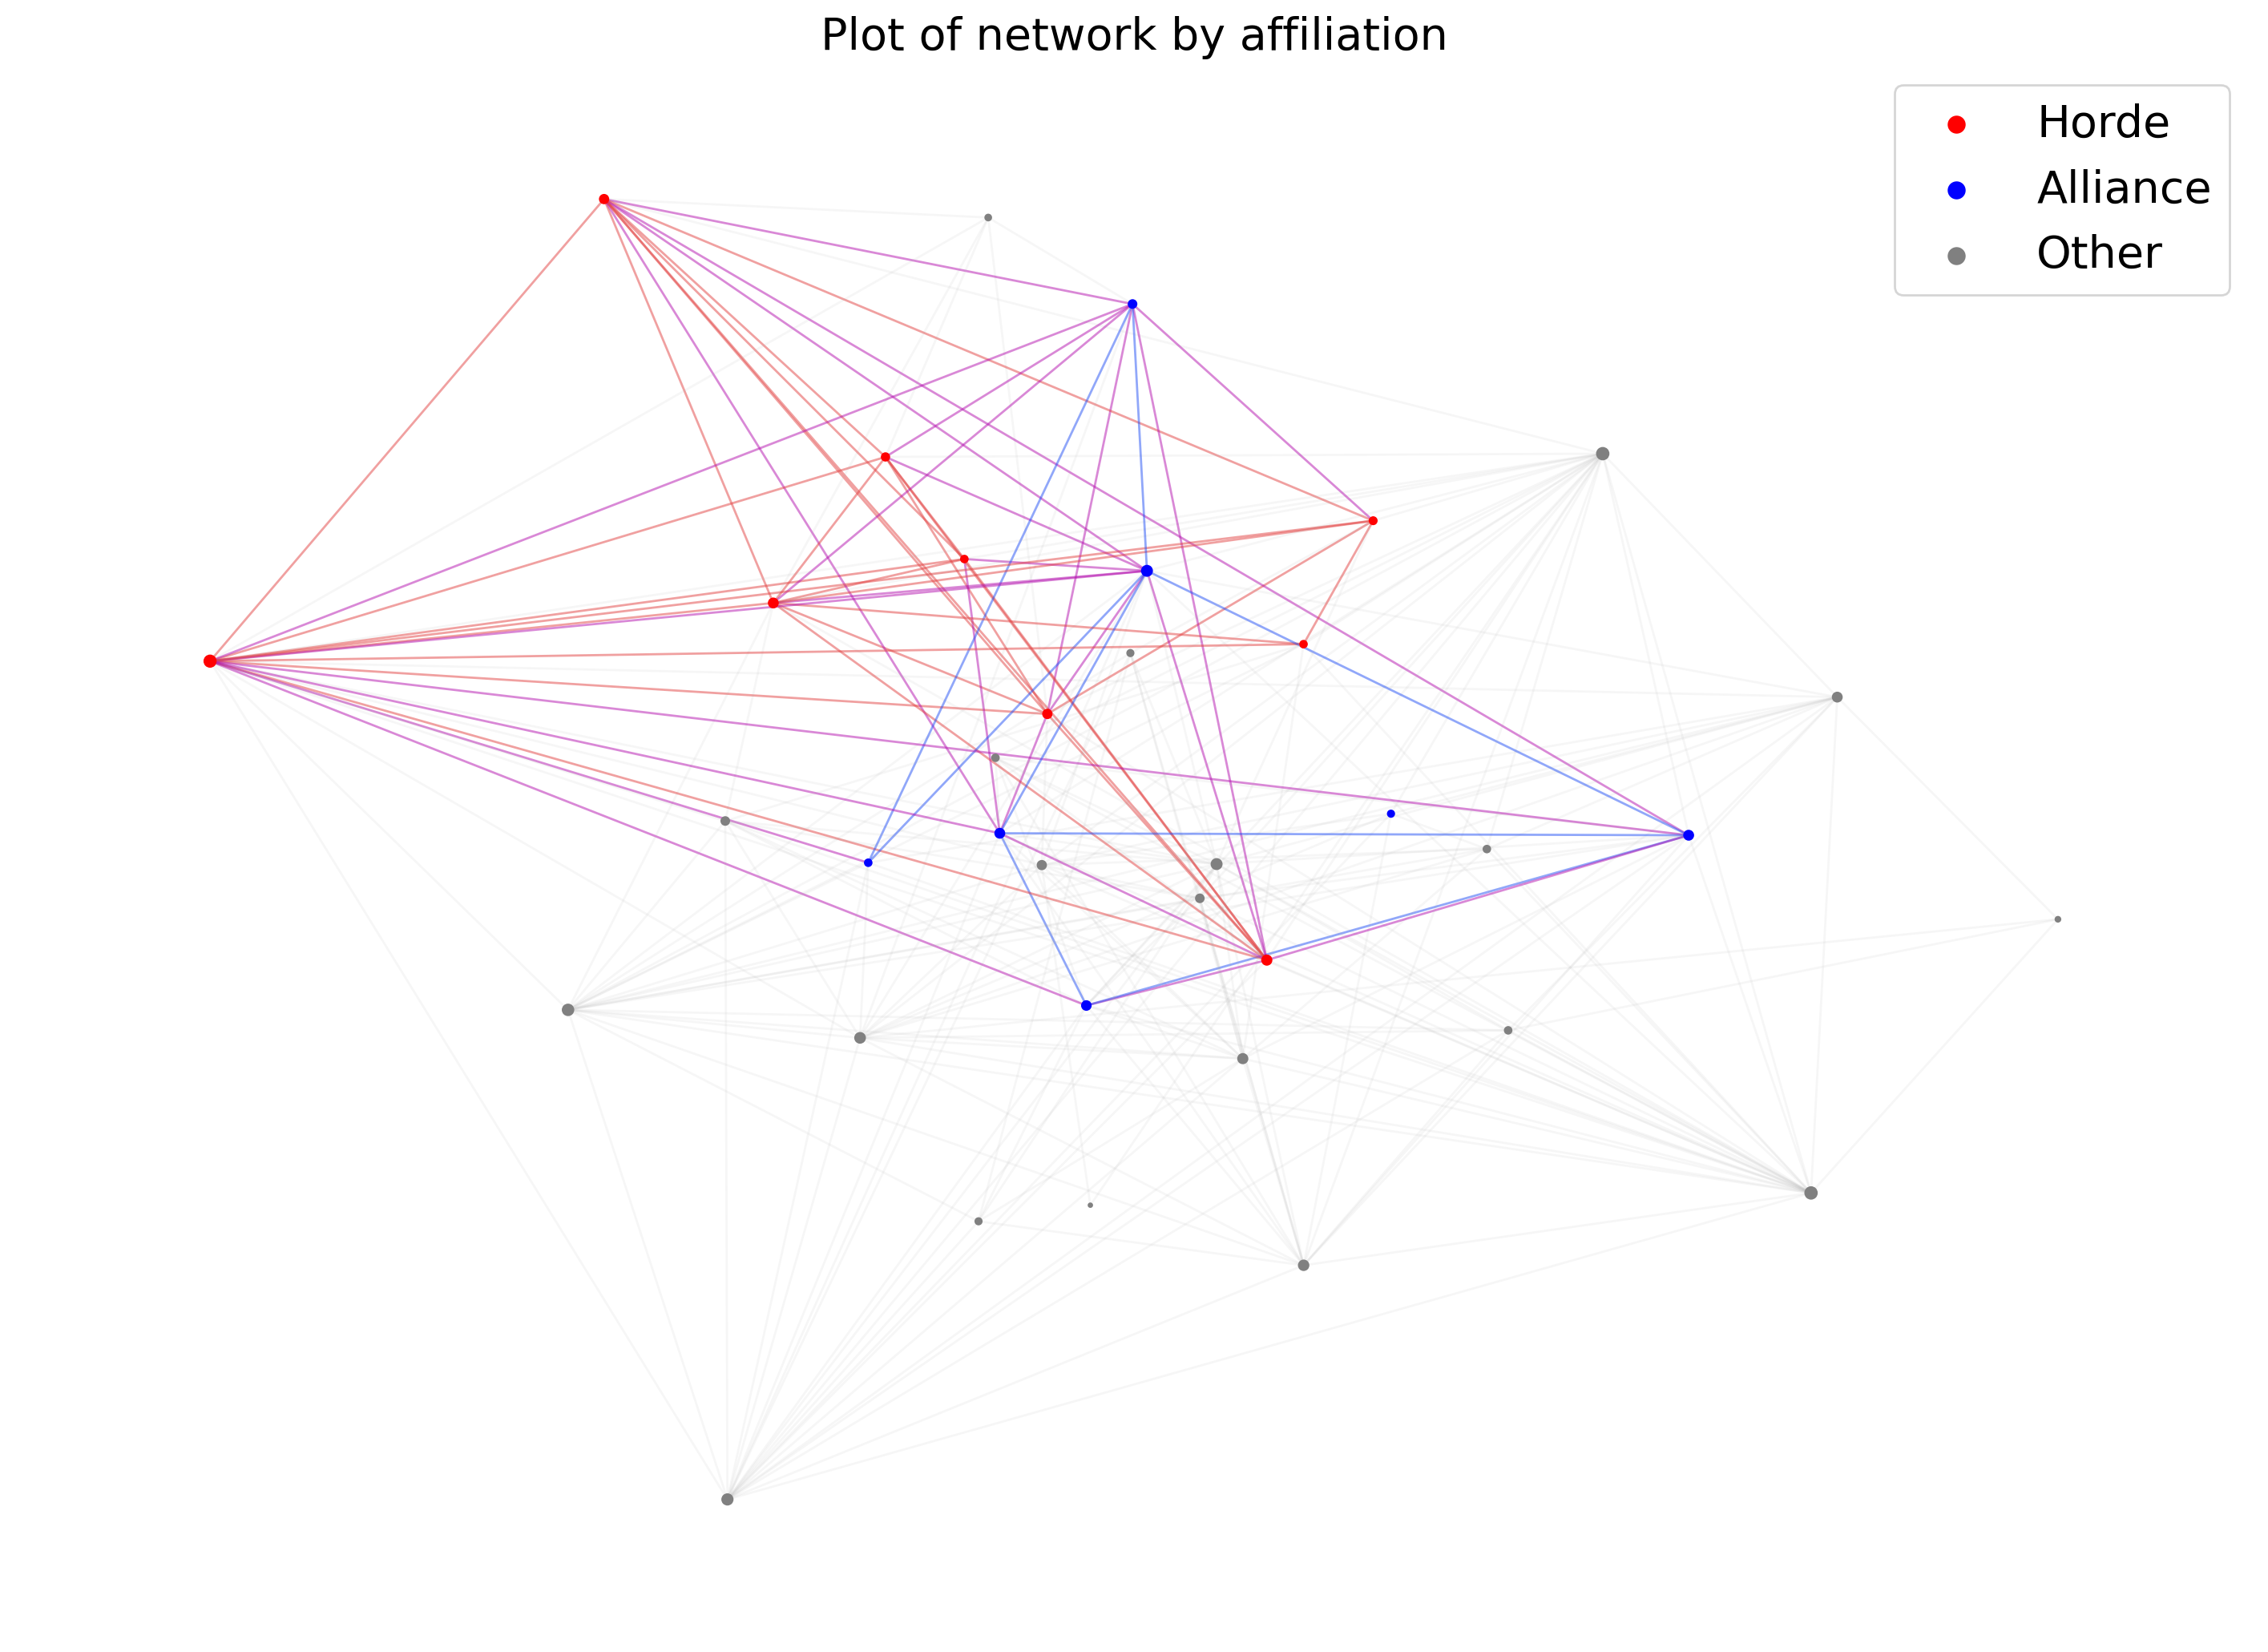

In [260]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        # Log
                        verbose=True)

fig = plt.figure(figsize=(18,13), dpi=200)
plt.title("Plot of network by affiliation", fontsize=20)
positions = forceatlas2.forceatlas2_networkx_layout(GWC1, pos=None, iterations=500)

nx.draw_networkx_nodes(GWC1, positions, node_size=[GWC1.degree()[node] for node in nodeAtsDict['Horde']], nodelist=nodeAtsDict['Horde'], node_color='red', label='Horde')
nx.draw_networkx_nodes(GWC1, positions, node_size=[GWC1.degree()[node] for node in nodeAtsDict['Alliance']], nodelist=nodeAtsDict['Alliance'], node_color='blue', label='Alliance')
nx.draw_networkx_nodes(GWC1, positions, node_size=[GWC1.degree()[node] for node in nodeAtsDict['Other']], nodelist=nodeAtsDict['Other'], node_color='grey', label='Other')
 
# nx.draw_networkx_labels(GWC1, positions, {'Thrall':'Thrall','Garrosh_Hellscream':'Garrosh_Hellscream'}, font_size=16, font_color='r')
# nx.draw_networkx_labels(GWC1, positions, {'Jaina_Proudmoore':'Jaina_Proudmoore'}, font_size=16, font_color='b')

nx.draw_networkx_edges(GWC1, positions, edge_color=edge_color, alpha=edge_alpha)


plt.axis('off')
lgnd = plt.legend(prop={'size': 20})
for handle in lgnd.legendHandles:
    handle.set_sizes([50.0])
plt.show()

## Communites over time

Denne her sektion er også outdatet, vi bruger det ikke i opgaven, og jeg tror ikke det virker


In [261]:
def computeModularity(G, partition):
    #Here the partition input is an attribute that we will partition the data set by
    partitions = np.unique(list(nx.get_node_attributes(G,partition).values()))
    partition_dic = {part: [] for part in partitions}
    
    N = len(G.nodes())
    L = len(G.edges())
    
    modularity = 0
    #sort nodes into their respective communities
    for key in partition_dic.keys():
        for node in G.nodes():
            part = G.nodes[node][partition]
            partition_dic[part].append(node)
        community = nx.Graph.subgraph(G, partition_dic[key])
        k_c = sum([G.degree(v) for v in community])
        L_c = len(community.edges())

        #compuute modularity
        modularity += (L_c / L) - (k_c/(2*L))**2
        
    return modularity
print("Modularity score affiliation partition:", round(computeModularity(GWC1,'Affiliation'),4))

Modularity score affiliation partition: 0.1158


In [262]:
import community

games = ['WC1','WC2','WC2X','WC3','WC3X','WoW','WoWBC','WoWWotLK','WoWC','WoWMoP','WoWWoD','WoWL','WoWBfA','WoWS','WoWD']

games_com = {}

for game in games:
    GWC = DG.subgraph(df_meta[df_meta[game]==1]['Name']).to_undirected()
    part = community.best_partition(GWC)
    games_com[game]=part
games_com

label = []
for game in games:
    label.extend(['{}'.format(game)+'_{}'.format(value) for value in set(games_com[game].values())])
label
source = []
for game in games:
    

IndentationError: expected an indented block (Temp/ipykernel_6556/122664874.py, line 19)

In [263]:
modularity = computeModularity(GWC1, 'louvain')
print("Modularity score Louvain partition:", round(modularity,4))

Modularity score Louvain partition: 0


In [264]:
GWC1.nodes('louvain')

NodeDataView({'Varimathras': None, 'Maiev_Shadowsong': None, "Vol'jin": None, 'Gazlowe': None, 'Rokhan': None, "Kel'Thuzad": None, "Ner'zhul": None, 'Balnazzar': None, 'Lich_King': None, 'Arthas_Menethil': None, "Kael'thas_Sunstrider": None, 'Othmar_Garithos': None, 'Elune': None, 'Cairne_Bloodhoof': None, 'Baine_Bloodhoof': None, 'Antonidas': None, "Kil'jaeden": None, 'Rexxar': None, 'Thrall': None, 'Sargeras': None, 'Jaina_Proudmoore': None, 'Akama': None, 'Chen_Stormstout': None, 'Daelin_Proudmoore': None, 'Lady_Vashj': None, "Anub'arak": None, "Drek'Thar": None, 'Sylvanas_Windrunner': None, 'Tyrande_Whisperwind': None, 'Magtheridon': None, 'Illidan_Stormrage': None, 'Malfurion_Stormrage': None, 'Nazgrel': None, 'Sapphiron': None, "Mug'thol": None, "Gul'dan": None}, data='louvain')

In [265]:
# parameters for nx.draw

degrees = [d[1] for d in nx.degree(GWC1)]
color_map = []
hex_cols = []

# from https://stackoverflow.com/questions/13998901/generating-a-random-hex-color-in-python
r = lambda: random.randint(0,255)
for i in range(len(np.unique(list(partition.values())))):
    hex_col = '#%02X%02X%02X' % (r(),r(),r())
    hex_cols.append(hex_col)

for com in partition.values():
    color_map.append(hex_cols[com])

NameError: name 'partition' is not defined

In [266]:
nodeAtsList = []
for i in range(len(np.unique(list(partition.values())))):
    nodesByAts = [x for x,y in GWC1.nodes(data=True) if y['louvain']==i]
    nodeAtsList.append(nodesByAts)

NameError: name 'partition' is not defined

In [267]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=30.0,

                        # Log
                        verbose=True)


fig = plt.figure(figsize=(25,20), dpi=400)
positions = forceatlas2.forceatlas2_networkx_layout(GWC1, pos=None, iterations=500)

# create the legend for each Louvain attribute
for i in range(len(np.unique(list(partition.values())))):
    nx.draw_networkx_nodes(GWC1, positions, node_size=[GWC1.degree()[node] for node in nodeAtsList[i]]
                           , nodelist = nodeAtsList[i], node_color=hex_cols[i], label = str(i))

# nx.draw_networkx_labels(GWC1, positions, {'Captain_America':'Captain America', 'Iron_Man':'Iron Man'}, font_size=16, font_color='r')

nx.draw_networkx_edges(GWC1, positions, edge_color="grey", alpha=0.05)
plt.title("{} Louvain communities".format(len(np.unique(list(partition.values())))), fontsize=40)
lgnd = plt.legend(prop = {'size':30}, loc="upper left")

for handle in lgnd.legendHandles:
    handle.set_sizes([300.0])

plt.axis('off')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2411.31it/s]

BarnesHut Approximation  took  0.04  seconds
Repulsion forces  took  0.11  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


NameError: name 'partition' is not defined

<Figure size 10000x8000 with 0 Axes>

## Sentiment over time


In [3]:
#Load LabMT word list as dataframe:
df_happy = pd.read_csv('Data_Set_S1.txt', skiprows=2, sep="\t")

First we define some functions that help us calculate the sentiment score.

In [4]:
def text2sentiment_freqdist(freqdist_dic):
    #function taken from our assignment 2
    
    # total happiness score
    happiness_score = 0
    # total count of tokens included in the sentiment score
    w = 0
    
    # iterate over tokens in freqdist
    for token in freqdist_dic.keys():
        # check if token is in the dataframe
        if token in list(df_happy['word']):
            token = token.lower()
            
            # get sentiment score of word and multiply it with how many times it appears in the text 
            score = float(df_happy.loc[df_happy['word'] == token]['happiness_average'])
            happiness_score += freqdist_dic[token]*score
            
            # add how many times the token appears to total count
            w += freqdist_dic[token]
    
    # if total token count is 0, return 0. Else divide total happiness score with total token count
    if w == 0:
           return 0
    else:
        return happiness_score / w

In [270]:
#the following is also from assignment 2 code:
for i, name in enumerate(tqdm(df_text['Name'])):   
    if name in DG.nodes():
        # tokenize text from character page and turn into FreqDist dictionary
        tokens = df_text['Clean Text'].iloc[i].split()
        freqdist_dic = nltk.FreqDist(tokens)
        
        # assign sentiment score as new attribute in the graph
        sentiment_score = text2sentiment_freqdist(freqdist_dic)
        DG.nodes()[name]['sentiment'] = sentiment_score

100%|██████████████████████████████████████████████████████████████████████████████| 1961/1961 [21:38<00:00,  1.51it/s]


In [156]:
mean_sent=np.mean([value for (name,value) in list(DG.nodes('sentiment'))]) #Find mean sentiment score for all characters
print('Mean sentiment score: ',mean_sent)

Mean sentiment score:  5.253193968264166


In [157]:
df_happy['happiness_average'].values.mean()#Mean sentiment for the word list that the sentiment scores are based on

5.375239679123459

In [158]:
#Find all Horde and Alliance characters
Horde = df_text[df_text.Affiliation=='Horde']['Name']
Alliance = df_text[df_text.Affiliation=='Alliance']['Name']
games = ['WC1','WC2','WC2X','WC3','WC3X','WoW','WoWBC','WoWWotLK','WoWC','WoWMoP','WoWWoD','WoWL','WoWBfA','WoWS'] #list of games/expansions considered for sentiment analysis.


In [76]:
#dictionaries for storing sentiment scores
games_sent = {}
games_sent_horde = {}
games_sent_alliance = {}
#Find sentiment scores for all Horde and Alliance characters that appear in a given game and append the score to the list of their respective faction. 
for game in tqdm(games): 
    h = []
    a = []
    for name in Horde:
        if name in df_meta[df_meta[game]==1].Name.values:
            h.append(DG.nodes()[name]['sentiment'])
    games_sent_horde[game]=np.mean(h)#Calculate mean sentiment score for Horde characters in the given game.
    for name in Alliance:
        if name in df_meta[df_meta[game]==1].Name.values:
            a.append(DG.nodes()[name]['sentiment'])
    games_sent_alliance[game]=np.mean(a)#Calculate mean sentiment score for Alliance characters in the given game.
games_sent = {'Horde':games_sent_horde, 'Alliance':games_sent_alliance}

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.83it/s]


In [155]:
#plot of mean sentiment
plt.figure(figsize=(7,5))
plt.plot(games_sent['Horde'].values(),'r',label='Horde')
plt.plot(games_sent['Alliance'].values(),'b',label='Alliance')
plt.title('Sentiment from game to game')

plt.xticks(range(len(games)),games,rotation=45)
plt.grid()
plt.ylabel('Sentiment score')
plt.xlabel('Game/Expansion')
plt.hlines(mean_sent,xmin=0,xmax=13, color='black',linestyles='--',label='Mean sentiment score')
plt.legend()
plt.show()

NameError: name 'games_sent' is not defined

<Figure size 504x360 with 0 Axes>

In [159]:
#Count how many characters of each faction that appear in each game.
#This is done similarly to how the sentiment score was calculated.
#For each character in a given game that belongs to either the Horde or the Alliance, the respective factions counter ticks up
#THis count only consideres major characters, since the game metadata only exists for them.
game_fac_h = {}
game_fac_a = {}
for game in tqdm(games):
    h_count = 0
    a_count = 0
    for name in Horde:
        if name in df_meta[df_meta[game]==1].Name.values:
            h_count +=1
                          
    for name in Alliance:
        if name in df_meta[df_meta[game]==1].Name.values:
            a_count +=1
    #the counts for each faction is saved for each game
    game_fac_h[game]=h_count
    game_fac_a[game]=a_count
game_fac={'Horde':game_fac_h,'Alliance':game_fac_a}

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.24it/s]


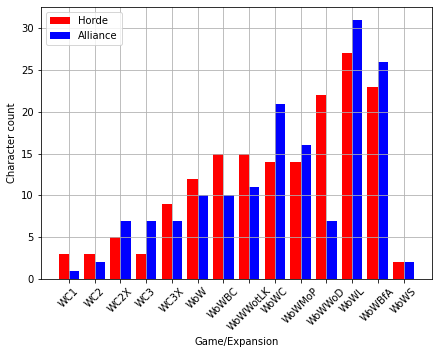

In [160]:
#Bar plot of Horde and Alliance character count.
horde_count=list(game_fac['Horde'].values())
alliance_count = list(game_fac['Alliance'].values())
plt.figure(figsize=(7,5))
plt.bar(np.array(range(len(game_fac['Horde'].keys())))-0.2,horde_count,color='r',tick_label=list(game_fac['Horde'].keys()),width=0.4,label='Horde')
plt.bar(np.array(range(len(game_fac['Alliance'].keys())))+0.2,alliance_count,color='b',tick_label=list(game_fac['Alliance'].keys()),width=0.4,label='Alliance')
plt.legend()
plt.xticks(range(len(games)),games,rotation=45)
plt.ylabel('Character count')
plt.xlabel('Game/Expansion')
plt.grid()
# plt.yscale('log')
# plt.title('Character count')
plt.show()


In [162]:
#save Graph with sentiment scores as attribute
filepath = os.getcwd()
with open(filepath+'\\DG_sent.pickle', 'wb') as handle:
    pickle.dump(DG, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [163]:
#DELETE, SANITY CHECK
# [DG.nodes()[name]['sentiment'] for name in df_meta[df_meta['WC3X']==1].Name.values]
sorted([(name,value) for (name,value) in list(DG.nodes('sentiment')) if name in df_meta[df_meta['WoWBfA']==1].Name.values])

[('Alexstrasza', 5.262036511156179),
 ('Alleria_Windrunner', 5.275795159896292),
 ('Anasterian_Sunstrider', 5.192595857205802),
 ('Anduin_Wrynn', 5.269455332451621),
 ('Arthas_Menethil', 5.2303492567469965),
 ('Aviana', 5.323767383059419),
 ('Aysa_Cloudsinger', 5.312276029055689),
 ('Baine_Bloodhoof', 5.252972027972032),
 ('Bolvar_Fordragon', 5.202445185055248),
 ('Brann_Bronzebeard', 5.3145750000000005),
 ('Broll_Bearmantle', 5.26758071107478),
 ('Cairne_Bloodhoof', 5.293601440576231),
 ('Chi-Ji', 5.226458684654293),
 ('Chronormu', 5.331105965676922),
 ('Daelin_Proudmoore', 5.208939475093725),
 ('Danath_Trollbane', 5.235684620376385),
 ('Darius_Crowley', 5.21981119352664),
 ('Draka', 5.236755634638194),
 ('Durotan', 5.180270684371808),
 ('Ebyssian', 5.252846199175016),
 ('Eitrigg', 5.237181069958841),
 ('Elune', 5.361281573498955),
 ('Falstad_Wildhammer', 5.236340097970604),
 ('First_Arcanist_Thalyssra', 5.271705744431416),
 ('Garona_Halforcen', 5.251886160714269),
 ('Garrosh_Hellscre

We want to understand what kind of characters gets high and low sentiment scores. We threshold the sentiment scores so only the most positive and negative texts remain.

In [164]:
evil_names=sorted([name for (name,value) in list(DG.nodes('sentiment')) if value<5])
good_names=sorted([name for (name,value) in list(DG.nodes('sentiment')) if value>5.6])
print(len(good_names),len(evil_names))

11 30


We see that there are more characters with a sentiment score under 5 than characters with a sentiment score over 5.6.
By reading the wiki-pages of the cahraceters with the lowest and highest sentiment scores, we see that they have very short texts. We now want to see if length of a characters wiki-page has an impact on the sentiment score.

In [165]:
#Calculate the mean ammount of characters in a text for characters with a sentiment score below 5 compared to those with a sentiment score above 5.3, and all characters
print(np.mean([len(str(df_text['Clean Text'][df_text['Name']==name].values)) for name in good_names]))
print(np.mean([len(str(df_text['Clean Text'][df_text['Name']==name].values)) for name in evil_names]))
print(np.mean([len(str(df_text['Clean Text'][df_text['Name']==name].values)) for name in df_text['Name']]))

863.5454545454545
632.8
5676.060173380928


We can see that the characters we found with our threshold of sentiment scores before, have relatively short texts in terms of amount of characters.

In [166]:
#Sort characters by sentiment scores
temp_sent_list = sorted([(value, name) for (name,value) in list(DG.nodes('sentiment'))])
sorted_sent = [value for (value,name) in temp_sent_list]
sorted_len = [len(nltk.FreqDist(str(df_text['Clean Text'][df_text['Name']==name].values).split())) for (value,name) in temp_sent_list]

We have now sorted the characters by sentiment score and found the length of their associated text by the amount of words(tokens). We can now plot the rolling average text length by the sentiment scores. The rolling average takes a window of 100 samples and averages them with a uniform weigthing. This smoothes the plot, making it easier to see the underlying trend.

0       58.0
1       26.0
2       56.0
3       63.0
4       38.0
        ... 
1956    15.0
1957    35.0
1958    13.0
1959    29.0
1960    17.0
Name: Length_of_text, Length: 1961, dtype: float64
0        58.000000
1        42.000000
2        46.666667
3        50.750000
4        48.200000
           ...    
1956    108.690000
1957    108.350000
1958    106.240000
1959    106.430000
1960    104.900000
Name: Length_of_text, Length: 1961, dtype: float64


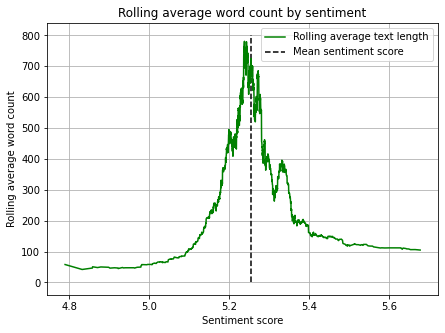

In [167]:
sent_len_df = pd.DataFrame(np.array([sorted_sent, sorted_len]).T,columns=['Sentiment_score','Length_of_text'])
print(sent_len_df['Length_of_text'])
rolled_series = sent_len_df['Length_of_text'].rolling(100,min_periods=1).mean()
print(rolled_series)
plt.figure(figsize=(7,5))
plt.plot(sorted_sent,rolled_series,'g',label='Rolling average text length')
# plt.yscale('log')
plt.title('Rolling average word count by sentiment')
plt.ylabel('Rolling average word count')
plt.xlabel('Sentiment score')
plt.vlines(mean_sent,ymin=0,ymax=800, color='black',linestyles='--',label='Mean sentiment score')
plt.grid()
plt.legend()

This shows us that the sentiment score of a text approaches the mean when as the text gets longer. So a long text will be more likely to have a sentiment score of around 5.25. 

In [168]:
#Find text length for each character appearing in each game
game_fac_h = {}
game_fac_a = {}
for game in tqdm(games):
    h_count = 0
    a_count = 0
    for name in Horde:
        if name in df_meta[df_meta[game]==1].Name.values:#find Horde characters that appeared in the given game
            h_count +=len(nltk.FreqDist(str(df_text['Clean Text'][df_text['Name']==name].values).split())) #Add their texts word count to the sum
                          
    for name in Alliance:
        if name in df_meta[df_meta[game]==1].Name.values:
            a_count +=len(nltk.FreqDist(str(df_text['Clean Text'][df_text['Name']==name].values).split()))
    #save the cumulative text lenght in terms of amount of tokens for each faction for each game.
    game_fac_h[game]=h_count 
    game_fac_a[game]=a_count
game_fac={'Horde':game_fac_h,'Alliance':game_fac_a}

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.49it/s]


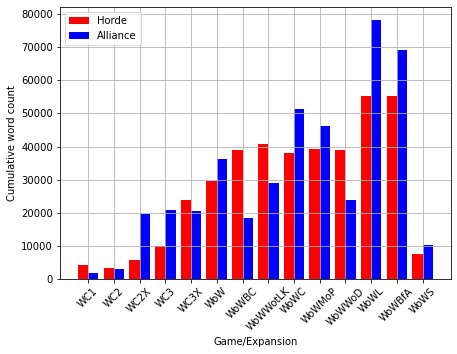

In [169]:
#plot cumulative word count
plt.figure(figsize=(7,5))
plt.bar(np.array(range(len(game_fac['Horde'].keys())))-0.2,list(game_fac['Horde'].values()),color='r',tick_label=list(game_fac['Horde'].keys()),width=0.4,label='Horde')
plt.bar(np.array(range(len(game_fac['Alliance'].keys())))+0.2,list(game_fac['Alliance'].values()),color='b',tick_label=list(game_fac['Alliance'].keys()),width=0.4,label='Alliance')
plt.legend()
plt.xticks(range(len(games)),games,rotation=45)
plt.ylabel('Cumulative word count')
plt.xlabel('Game/Expansion')
plt.grid()
# plt.yscale('log')
# plt.title('Character count')
plt.show()


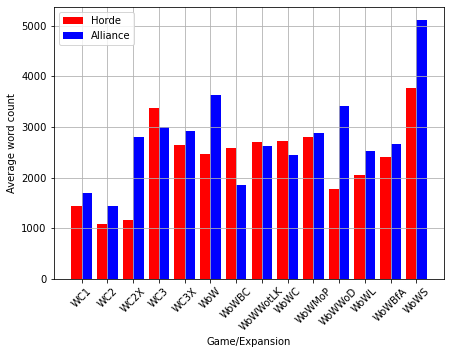

In [170]:
#Calculate mean length of text(word count) for each character of each faction in a given game.
h_val = np.divide(np.array(list(game_fac['Horde'].values())),np.array(horde_count))
a_val = np.divide(np.array(list(game_fac['Alliance'].values())),np.array(alliance_count))
plt.figure(figsize=(7,5))
plt.bar(np.array(range(len(game_fac['Horde'].keys())))-0.2,h_val,color='r',tick_label=list(game_fac['Horde'].keys()),width=0.4,label='Horde')
plt.bar(np.array(range(len(game_fac['Alliance'].keys())))+0.2,a_val,color='b',tick_label=list(game_fac['Alliance'].keys()),width=0.4,label='Alliance')
plt.legend()
plt.xticks(range(len(games)),games,rotation=45)
plt.ylabel('Average word count')
plt.xlabel('Game/Expansion')
plt.grid()
# plt.yscale('log')
# plt.title('Character count')
plt.show()

In [280]:
#Calculate the mean sentiment scores of each faction. Includes all characters from all games + non-major characters.
h_sent = []
a_sent = []
for name in Horde:
    h_sent.append(DG.nodes()[name]['sentiment'])
horde_sent = np.mean(h_sent)
for name in Alliance:
    a_sent.append(DG.nodes()[name]['sentiment'])
alliance_sent = np.mean(a_sent)
print('Alliance Sentiment score: {}'.format(alliance_sent),'\nHorde Sentiment score: {}'.format(horde_sent))
    

Alliance Sentiment score: 5.251297883405995 
Horde Sentiment score: 5.222782740899875


In [282]:
print("Number of Horde characters:", len(Horde))
print("Number of Alliance characters:", len(Alliance))



Number of Horde characters: 119
Number of Alliance characters: 99


We want to see the summary statistics of the sentiment scores for Horde and Alliance, as in assigment 2.

In [283]:
# calculate mean, median, 10th percentile, 90th percentile for Alliance characters
a_sent = [a for a in a_sent if a != 0] # remove 0s
mean = alliance_sent
median = np.median(a_sent)
p10 = np.percentile(a_sent, q=10)
p90 = np.percentile(a_sent, q=90)

print("Statistics for Alliance characters")
print("Mean:", round(mean,3))
print("Median", round(median,3))
print("10th percentile", round(p10,3))
print("90th percentile", round(p90,3))

Statistics for good characters
Mean: 5.251
Median 5.244
10th percentile 5.19
90th percentile 5.315


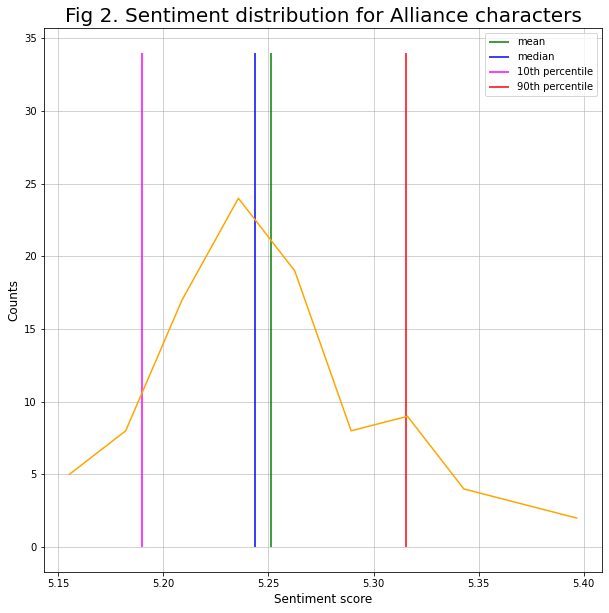

In [284]:
height, bins = np.histogram(a_sent, bins=10)

binmids = []
for i in range(len(bins)-1):
    binmids.append((bins[i]+bins[i+1])/2)
    
    
fig, ax = plt.subplots(1 ,figsize=(10,10))

plt.title('Fig 2. Sentiment distribution for Alliance characters', size=20)
plt.xlabel('Sentiment score', size=12)
plt.ylabel('Counts', size=12)
plt.plot(binmids, height, color='orange')
plt.grid(alpha=0.7)
plt.rc('axes', axisbelow=True)
plt.vlines(mean, 0, max(height)+10, color='green', label='mean')
plt.vlines(median, 0, max(height)+10, color='blue', label='median')
plt.vlines(p10, 0, max(height)+10, color='magenta', label='10th percentile')
plt.vlines(p90, 0, max(height)+10, color='red', label='90th percentile')
plt.legend();


## Horde characters

We also compute the mean, median, 10th percentile, and 90th percentile for the bad characters and plot the distribution of sentiment values.

In [285]:
# calculate mean, median, 10th percentile, 90th percentile for bad characters
h_sent = [b for b in h_sent if b != 0] # remove 0s
mean = np.mean(h_sent)
median = np.median(h_sent)
p10 = np.percentile(h_sent, q=10)
p90 = np.percentile(h_sent, q=90)

print("Statistics for horde characters")
print("Mean:", round(mean,3))
print("Median", round(median,3))
print("10th percentile", round(p10,3))
print("90th percentile", round(p90,3))

Statistics for horde characters
Mean: 5.223
Median 5.237
10th percentile 5.126
90th percentile 5.318


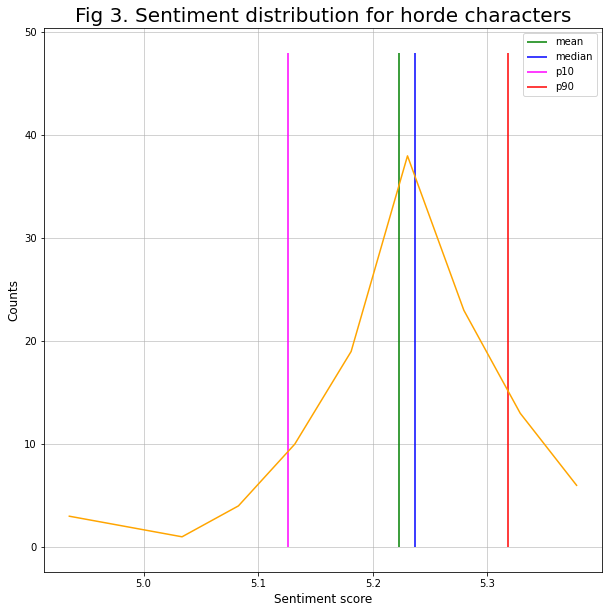

In [286]:
height, bins = np.histogram(h_sent, bins=10)

binmids = []
for i in range(len(bins)-1):
    binmids.append((bins[i]+bins[i+1])/2)
    
    
fig, ax = plt.subplots(1 ,figsize=(10,10))

plt.title('Fig 3. Sentiment distribution for horde characters', size=20)
plt.xlabel('Sentiment score', size=12)
plt.ylabel('Counts', size=12)
plt.plot(binmids, height, color='orange')
plt.grid(alpha=0.7)
plt.rc('axes', axisbelow=True)
plt.vlines(mean, 0, max(height)+10, color='green', label='mean')
plt.vlines(median, 0, max(height)+10, color='blue', label='median')
plt.vlines(p10, 0, max(height)+10, color='magenta', label='p10')
plt.vlines(p90, 0, max(height)+10, color='red', label='p90')
plt.legend();
# plt.xlim(min_, max_+1);

In [287]:
def get_horde_and_alliance_graph(G):

    alliance_subgraph = [n for n in DG.nodes() if n in Alliance.values]
    alliance = G.subgraph(alliance_subgraph)

    horde_subgraph = [n for n in DG.nodes() if n in Horde.values]
    horde = G.subgraph(horde_subgraph)

    return alliance, horde

In [288]:
def get_permuted_sentiments(graph):
    # get number of nodes of graph
    M = len(graph.nodes())
    print("Number of characters:", M)
    
    permuted_sentiments = []
    # permute 1000 times
    for i in tqdm(range(1000)):
        # randomly choose M nodes from graph G
        permute = random.sample(list(DG.nodes()), M)
        
        # get sentiment and append
        sentiment = np.mean([DG.nodes()[node]['sentiment'] for node in permute if DG.nodes()[node]['sentiment'] != 0])
        permuted_sentiments.append(sentiment)
    
    return permuted_sentiments

In [289]:
# get Alliance and Horde partition
alliance, horde = get_horde_and_alliance_graph(DG)

# get sentiments of good and bad characters respectively
avg_sentiment_A = [DG.nodes[node]['sentiment'] for node in alliance.nodes()]
avg_sentiment_H = [DG.nodes[node]['sentiment'] for node in horde.nodes()]

In [290]:
# mean sentiment values
print("Mean sentiment value for alliance characters:", round(np.mean(avg_sentiment_A),3))
print("Mean sentiment value for horde characters:", round(np.mean(avg_sentiment_H),3))

Mean sentiment value for alliance characters: 5.251
Mean sentiment value for horde characters: 5.223


Number of characters: 99


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2457.02it/s]


The mean of the distribution is: 5.253


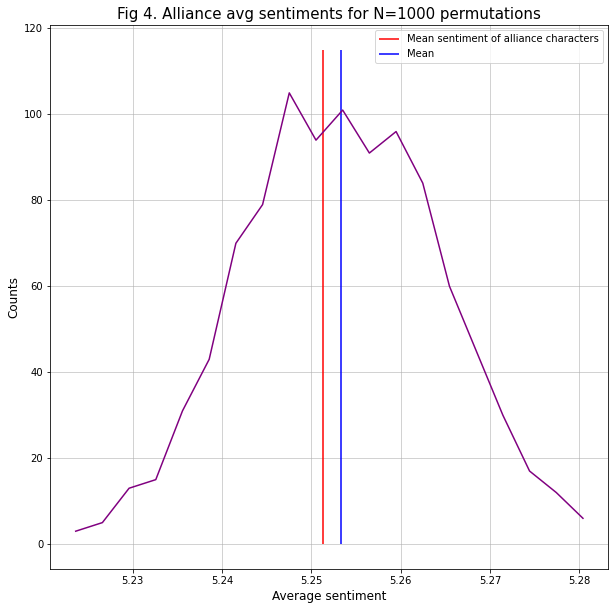

In [291]:
#Alliance
sentiment_As = get_permuted_sentiments(alliance)

print("The mean of the distribution is:", round(np.mean(sentiment_As),3))

minX, maxX  = min(sentiment_As), max(sentiment_As)

height, bins = np.histogram(sentiment_As, bins=20)

binmids = []
for i in range(len(bins)-1):
    binmids.append((bins[i]+bins[i+1])/2)

fig, ax = plt.subplots(1 ,figsize=(10,10))    
    
plt.title('Fig 4. Alliance avg sentiments for N=1000 permutations', size=15)
plt.xlabel('Average sentiment', size=12)
plt.ylabel('Counts', size=12)
plt.plot(binmids, height, color='purple')
plt.grid(alpha=0.7)
plt.vlines(np.mean(avg_sentiment_A), 0, max(height)+10, color='red', label='Mean sentiment of alliance characters')
plt.vlines(np.mean(sentiment_As), 0, max(height)+10, color='blue', label='Mean')
plt.legend()
plt.rc('axes', axisbelow=True)

Number of characters: 119


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2207.54it/s]


The mean of the distribution is: 5.253


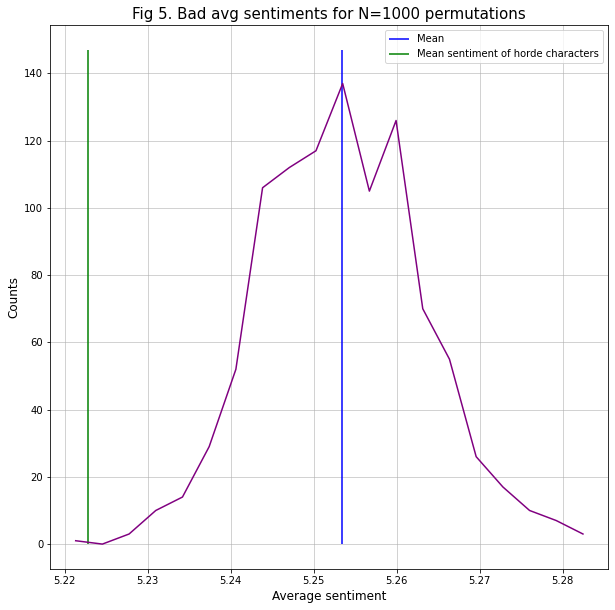

In [292]:
# Horde
sentiment_Hs = get_permuted_sentiments(horde)

print("The mean of the distribution is:", round(np.mean(sentiment_Hs),3))

minX, maxX  = min(sentiment_Hs), max(sentiment_Hs)

height, bins = np.histogram(sentiment_Hs, bins=20)

binmids = []
for i in range(len(bins)-1):
    binmids.append((bins[i]+bins[i+1])/2)

fig, ax = plt.subplots(1 ,figsize=(10,10))    
    
plt.title('Fig 5. Horde avg sentiments for N=1000 permutations', size=15)
plt.xlabel('Average sentiment', size=12)
plt.ylabel('Counts', size=12)
plt.plot(binmids, height, color='purple')
plt.grid(alpha=0.7)
plt.vlines(np.mean(sentiment_Hs), 0, max(height)+10, color='blue', label="Mean")
plt.vlines(np.mean(avg_sentiment_H), 0, max(height+10), color='green', label="Mean sentiment of horde characters")
plt.legend()
plt.rc('axes', axisbelow=True)

### Directed Sentiment: Sentiment between factions
Are the horde more hostile towards the alliance or opposite. Do they always interact in negative situations or do they share good times?

In [117]:
#load dictionary of character aliases. Needed later
with open('max_char2aliases.pickle', 'rb') as f:
    max2A_dic = pickle.load(f)

In [144]:
success_count = 0
fail_count = 0
attribute_dic = {} #define dictionary to save sentiment scores
for name in tqdm(DG.nodes()): #loop over characters
    for char in df_text['Out Links'][df_text['Name']==name].values[0]: #Loop over the characters link to
        reg_exp = '[^.]*{}.[^.]*\.'.format(char.replace('_',' ')) #Use regex to find sentences where the characters are mentioned
        text = str(df_text['Clean Text'][df_text['Name']==name].values).replace('\\','')
        match = re.findall(reg_exp, text)
#         print(name,char,match)
        
 
        try:
            aliases = max2A_dic[char] #if character has aliases, check if their aliases are mentioned
            for alias in aliases:
                reg_exp = '[^.]*{}.[^.]*\.'.format(alias.replace('_',' '))
                alias_match = re.findall(reg_exp, text)
                for item in alias_match:
                    if item not in match:#Only add sentences that were not already found. Necessary as some characters aliases are subsets of their name(e.g first name only).
#                         print('Alias:',item,'Match:', match, name, char)
                        match.append(item)
                        
#                     print('success for:',name,char)
        except:
                None
        if match!=[]:
            tokens = [t.split() for t in match]#split text into tokens
            tokens = [item for sublist in tokens for item in sublist]
            freqdist_dic = nltk.FreqDist(tokens) 
            sentiment_score = text2sentiment_freqdist(freqdist_dic)#calculate sentiment score for all tokens.
            attribute_dic[(name,char)]=(sentiment_score,match)#save sentiment score for edge
            success_count +=1
        else:#If the character is linked to on a characters page, but does not appear in the clean text, we ignore that particular edge.
#             print('oops, problem with',name,char)
            fail_count +=1
   

100%|██████████████████████████████████████████████████████████████████████████████| 1961/1961 [29:58<00:00,  1.09it/s]


There are 643 links where the linked characters are not mentioned in the clean text. These are simply disregarded for the directed sentiment analysis.

In [145]:
nx.set_edge_attributes(DG, attribute_dic, 'Sentiment_edge')#Save the sentiment as edge attributes

In [146]:
#sainty check, can be deleted
nx.get_edge_attributes(DG,'Sentiment_edge')
# print(success_count, fail_count)

{('Terokk', 'Anzu'): (5.354210526315788,
  [' Anzu, the great dread raven god, urged Terokk forward.',
   ' They moved through the Sethekk Hollow until they came across The Eye of Anzu and met Anzu for the first time.',
   'nnAnzu gifted Terokk and his followers dark powers and arcane sorcery.',
   ' Together, Terokk, Anzu, and the Talonpriests would build the refuge city of Skettis among Apexis ruins and protect the unwanted children of Rukhmar: the Arakkoa Outcasts.']),
 ('Terokk', 'Darkweaver_Syth'): (5.3707692307692305,
  [" The mask is held by Darkweaver Syth.n: Terokk's book is a powerful tome that increases spell damage and healing."]),
 ('Terokk', 'Hazzik'): (5.154999999999999,
  [" He began to hate the world, abandoning Skettis and even sacrificing the lower castesHazzik's Bargain of his own people to dark powers in search of a cure.",
   " Working with Hazzik, adventurers summoned the maddened husk of the Talon King before he was ready and ended the once mighty arakkoa's life

In [147]:
#save graph with edge attributes and the attribute dictionary
filepath = os.getcwd()
with open(filepath+'\\DG_sent.pickle', 'wb') as handle:
    pickle.dump(DG, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(filepath+'\\edge_sent_dic.pickle', 'wb') as handle:
    pickle.dump(attribute_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [148]:
#Calculate means for faction to faction sentiment
for edge in DG.edges():
    if edge in attribute_dic.keys():#check if sentiment has been calculated for the edge
        if edge[0] in Alliance.values and edge[1] in Alliance.values:#Alliance to alliance sentiment
            A2A.append(attribute_dic[edge][0])
        elif edge[0] in Alliance.values and edge[1] in Horde.values:#Alliance to horde sentiment
            A2H.append(attribute_dic[edge][0])
        elif edge[0] in Horde.values and edge[1] in Alliance.values:#Horde to alliance sentiment
            H2A.append(attribute_dic[edge][0])
        elif edge[0] in Horde.values and edge[1] in Horde.values:#Horde to horde sentiment
            H2H.append(attribute_dic[edge][0])
print('Mean sentiment for Alliance to Alliance:',np.mean(A2A))
print('Mean sentiment for Alliance to Horde:',np.mean(A2H))
print('Mean sentiment for Horde to Alliance:',np.mean(H2A))
print('Mean sentiment for Horde to Horde:',np.mean(H2H))
        

Mean sentiment for Alliance to Alliance: 5.244740014158619
Mean sentiment for Alliance to Horde: 5.2214226725570105
Mean sentiment for Horde to Alliance: 5.204189698125854
Mean sentiment for Horde to Horde: 5.227197251684637


In [149]:
#Sanity check, delete?
for edge in DG.edges():
    print(attribute_dic[edge][0])
    break
('Brann_Bronzebeard','Dagran_Thaurissan_II') in nx.get_edge_attributes(DG,'Sentiment_edge').keys()

5.354210526315788


False

In [13]:
#Load previoulsy saved dicts, could be deleted for final assignment
with open('DG_sent.pickle', 'rb') as f:
    DG = pickle.load(f)
with open('edge_sent_dic.pickle', 'rb') as f:
    attribute_dic = pickle.load(f)

Now that we have calculated the sentiment for each character pair, we can find the mean directed sentiment for major characters of each faction that appear in each game/expansion, as we did with regular sentiment score before.

In [150]:
#Find all Horde and Alliance characters
Horde = df_text[df_text.Affiliation=='Horde']['Name']
Alliance = df_text[df_text.Affiliation=='Alliance']['Name']
#same games list as earlier
games = ['WC1','WC2','WC2X','WC3','WC3X','WoW','WoWBC','WoWWotLK','WoWC','WoWMoP','WoWWoD','WoWL','WoWBfA','WoWS']


games_sent_d = {}
games_sent_A2A = {}
games_sent_A2H = {}
games_sent_H2A = {}
games_sent_H2H = {}
character_sent = {}
for game in tqdm(games):
    A2A = []
    A2H = []
    H2A = []
    H2H = []
    h = []
    a = []
    for edge in DG.edges():
        if edge[0] in df_meta[df_meta[game]==1].Name.values and edge in attribute_dic.keys():           
            if edge[0] in Alliance.values and edge[1] in Alliance.values:
                A2A.append(attribute_dic[edge][0])
            elif edge[0] in Alliance.values and edge[1] in Horde.values:
                A2H.append(attribute_dic[edge][0])
            elif edge[0] in Horde.values and edge[1] in Alliance.values:
                H2A.append(attribute_dic[edge][0])
            elif edge[0] in Horde.values and edge[1] in Horde.values:
                H2H.append(attribute_dic[edge][0])
    #Save mean directed sentiment for each faction to faction combination
    games_sent_A2A[game]=np.mean(A2A)
    games_sent_A2H[game]=np.mean(A2H)
    games_sent_H2A[game]=np.mean(H2A)
    games_sent_H2H[game]=np.mean(H2H)
games_sent_d = {'A2A':games_sent_A2A, 'A2H':games_sent_A2H,'H2A':games_sent_H2A, 'H2H':games_sent_H2H }


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:26<00:00,  6.19s/it]


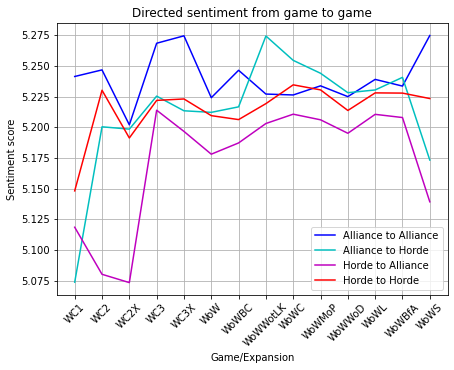

In [152]:
#plot directed sentiment over time.
plt.figure(figsize=(7,5))
plt.plot(games_sent_d['A2A'].values(),'b')
plt.plot(games_sent_d['A2H'].values(),'c')
plt.plot(games_sent_d['H2A'].values(),'m')
plt.plot(games_sent_d['H2H'].values(),'r')
plt.title('Directed sentiment from game to game')
# plt.hlines(mean_sent,xmin=0,xmax=13, color='black',linestyles='--',label='Mean Sentiment score')
plt.legend(['Alliance to Alliance','Alliance to Horde','Horde to Alliance','Horde to Horde','Mean sentiment score'])
plt.xticks(range(len(games)),games,rotation=45)
plt.grid()
plt.ylabel('Sentiment score')
plt.xlabel('Game/Expansion')
plt.show()

We see that the Alliance to Horde sentiment is surprisingly high for WoWWotLK. We want to look closer as to why. To do this, we find the Alliance to Horde edge with the highest sentiment score.

In [189]:

temp_list=[char for char in df_meta[df_meta['WoWWotLK']==1].Name.values if char in Alliance.values]
temp_list2 =[char for char in df_meta[df_meta['WoWWotLK']==1].Name.values if char in Horde.values]
# Horde.values
temp_edges=[edge for edge in attribute_dic.keys() if edge[0] in temp_list and edge[1] in temp_list2]
temp_edges
# [(name,value) for ]
A2H_max_s=sorted([attribute_dic[item] for item in temp_edges])
    
print(A2H_max_s[-1],A2H_max_s[-2])


(5.586666666666666, ["nnThe Vow EternalnnMuradin and his family were among those who attended the wedding of Lor'themar Theron and Thalyssra."]) (5.586666666666666, ["nnThe Vow EternalnnBrann and his family were among those who attended the wedding of Lor'themar Theron and Thalyssra."])


The edge with the highest sentiment score is actually to edges with almost identical text. This is for both Muradin and Brann Bronzebeard to Lor'themar Theron. The text explains that the dwarves attended Lor'themar's wedding.